In [1]:
import sys
import os
import numpy as np
from PIL import Image
from flax.training import checkpoints
import traceback
from jaxrl_m.vision import encoders
from jaxrl_m.agents import agents
from jaxrl_m.data.bridge_dataset import multi_embed
from jaxrl_m.data.language import load_mapping, lang_encode
from jaxrl_m.vision.clip import process_image, process_text
from absl import app, flags, logging

import time
from datetime import datetime
from experiments.kevin.configs.bridgedata_config import get_config
import jax
import time
import tensorflow as tf
import jax.numpy as jnp
from flax.core import FrozenDict

import nest_asyncio
import json
nest_asyncio.apply()

FIXED_STD = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

def unnormalize_action(action, mean, std):
    return action * std + mean

2023-08-20 20:20:34.590748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lawrence/miniconda3/envs/jaxrl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NAME = "all_multimodal_lawrence_lcbc_20230817_002757"
STEP = 20_000
wandb_run = f"widowx-gcrl/jaxrl_m_bridgedata/{NAME}"
checkpoint_path = f"checkpoint_{STEP}"

#api = wandb.Api()
#run = api.run(wandb_run)
class run: config = json.load(open("run_config_ur5.json", "rb")) # use cached config to avoid wandb login

encoder_def = encoders[run.config["encoder"]](**run.config["encoder_kwargs"])
task_encoder_defs = {
    k: encoders[run.config["task_encoders"][k]](
        **run.config["task_encoder_kwargs"][k]
    )
    for k in ("image", "language")
    if k in run.config["task_encoders"]
}

action_metadata = run.config["bridgedata_config"]["action_metadata"]
action_mean = np.array(action_metadata["mean"])
action_std = np.array(action_metadata["std"])

In [3]:
# load_mapping(run.config["data_path"])

import jaxrl_m.data.language
from jaxrl_m.data.language import load_mapping, lang_encode

jaxrl_m.data.language.lang_to_code = {
 'Pick up the blue cup and put it into the brown cup.': 0,
 'Put the ranch bottle into the pot.': 1,
 'Take the tiger out of the red bowl and put it in the grey bowl.': 2,
 'Sweep the green cloth to the left side of the table.': 3,
 'Put the marker into the bowl.': 4
}

jaxrl_m.data.language.code_to_lang = {
 0: 'Pick up the blue cup and put it into the brown cup.',
 1: 'Put the ranch bottle into the pot.',
 2: 'Take the tiger out of the red bowl and put it in the grey bowl.',
 3: 'Sweep the green cloth to the left side of the table.',
 4: 'Put the marker into the bowl.'
}

example_batch = {
    "observations": {"image": jnp.zeros((10, 128, 128, 3), dtype=jnp.uint8)},
    "initial_obs": {"image": jnp.zeros((10, 128, 128, 3), dtype=jnp.uint8)},
    "goals": {
        "image": jnp.zeros((10, 128, 128, 3), dtype=jnp.uint8),
        "language": jnp.zeros((10, 512)),
        "language_mask": jnp.ones(10, dtype=bool),
    },
    "actions": jnp.zeros((10, 7), dtype=jnp.float32),
}

rng = jax.random.PRNGKey(0)
rng, construct_rng = jax.random.split(rng)
agent = agents[run.config["agent"]].create(
    rng=construct_rng,
    observations=example_batch["observations"],
    initial_obs=example_batch["initial_obs"],
    goals=example_batch["goals"],
    actions=example_batch["actions"],
    encoder_def=encoder_def,
    task_encoder_defs=task_encoder_defs,
    **run.config["agent_kwargs"],
)
restored = checkpoints.restore_checkpoint(checkpoint_path, agent)
assert restored is not agent
agent = restored

optimizer partitions:
FrozenDict({
    contrastive_temp: 'encoder',
    encoders_actor_0: {
        Dense_0: {
            bias: 'actor',
        },
    },
    networks_actor: {
        MLP_0: {
            layers_2: {
                bias: 'actor',
                kernel: 'actor',
            },
        },
    },
})


In [4]:
val_data = jnp.load('ur5_val/out.npy', allow_pickle=True)

def get_trans(idx, time):
    return (
        val_data[idx]["observations"][0]["images0"],
        val_data[idx]["observations"][time]["images0"], 
        val_data[idx]['language'][time].item(),
    )

In [5]:
def predict_actions(initial_obs, current_obs, language):
    return agent.sample_actions(
        dict(image=current_obs),
        dict(language=multi_embed(language)),
        dict(image=initial_obs),
        seed=rng,
        modality="language",
        argmax=True,
    )

In [6]:
predict_actions(*get_trans(idx=0, time=10))

Array([-0.64833874,  0.59965414,  0.9093299 ,  0.12440258, -0.01953199,
        0.11878116, -0.00923905], dtype=float32)

In [7]:
a = predict_actions(*get_trans(idx=2, time=10))
print(a)
print(action_mean)
print(action_std)
print(unnormalize_action(a, action_mean, action_std))

[-0.82612664  0.6140019   0.1855534  -0.00595688  0.06338147 -0.0304981
 -0.00722137]
[0 0 0 0 0 0 0]
[0.02       0.02       0.02       0.06666667 0.06666667 0.06666667
 1.        ]
[-0.01652253  0.01228004  0.00371107 -0.00039713  0.00422543 -0.00203321
 -0.00722137]


In [19]:
data = get_trans(idx=7, time=10)
print(data[2])

Pick up the blue cup and put it into the brown cup. 


In [9]:
data[0]

array([[[  0,  32,  74],
        [  1,  32,  76],
        [  0,  32,  69],
        ...,
        [189, 188, 181],
        [176, 172, 166],
        [166, 164, 156]],

       [[  0,  33,  73],
        [  0,  32,  75],
        [  0,  30,  73],
        ...,
        [169, 167, 163],
        [158, 159, 155],
        [156, 157, 153]],

       [[  0,  35,  75],
        [  0,  32,  75],
        [  0,  32,  76],
        ...,
        [152, 155, 150],
        [152, 153, 149],
        [155, 156, 150]],

       ...,

       [[ 54,  59,  40],
        [ 56,  62,  40],
        [ 62,  64,  44],
        ...,
        [ 85, 108, 111],
        [ 83, 106, 112],
        [ 81, 104, 112]],

       [[ 58,  63,  39],
        [ 53,  57,  35],
        [ 52,  55,  35],
        ...,
        [ 83, 105, 117],
        [ 83, 105, 113],
        [ 83, 105, 111]],

       [[ 53,  57,  32],
        [ 46,  48,  28],
        [ 51,  54,  33],
        ...,
        [ 83, 105, 114],
        [ 83, 103, 111],
        [ 83, 103, 110]]

In [22]:
traj_idx = 7
traj_len = len(val_data[traj_idx]["observations"])

actual_actions = [[] for _ in range(8)]
predicted_actions = [[] for _ in range(8)]

for i in range(traj_len):
    predicted_action = predict_actions(*get_trans(idx=traj_idx, time=i))
    action = np.append(unnormalize_action(predicted_action[:-1], action_mean[:-1], action_std[:-1]), predicted_action[-1])
    actual_action = val_data[traj_idx]['actions'][i]

    # print('actual_action:', actual_action)
    # print('predicted action:',action)
    for dim in range(7):
        actual_actions[dim].append(actual_action[dim])
        predicted_actions[dim].append(action[dim])

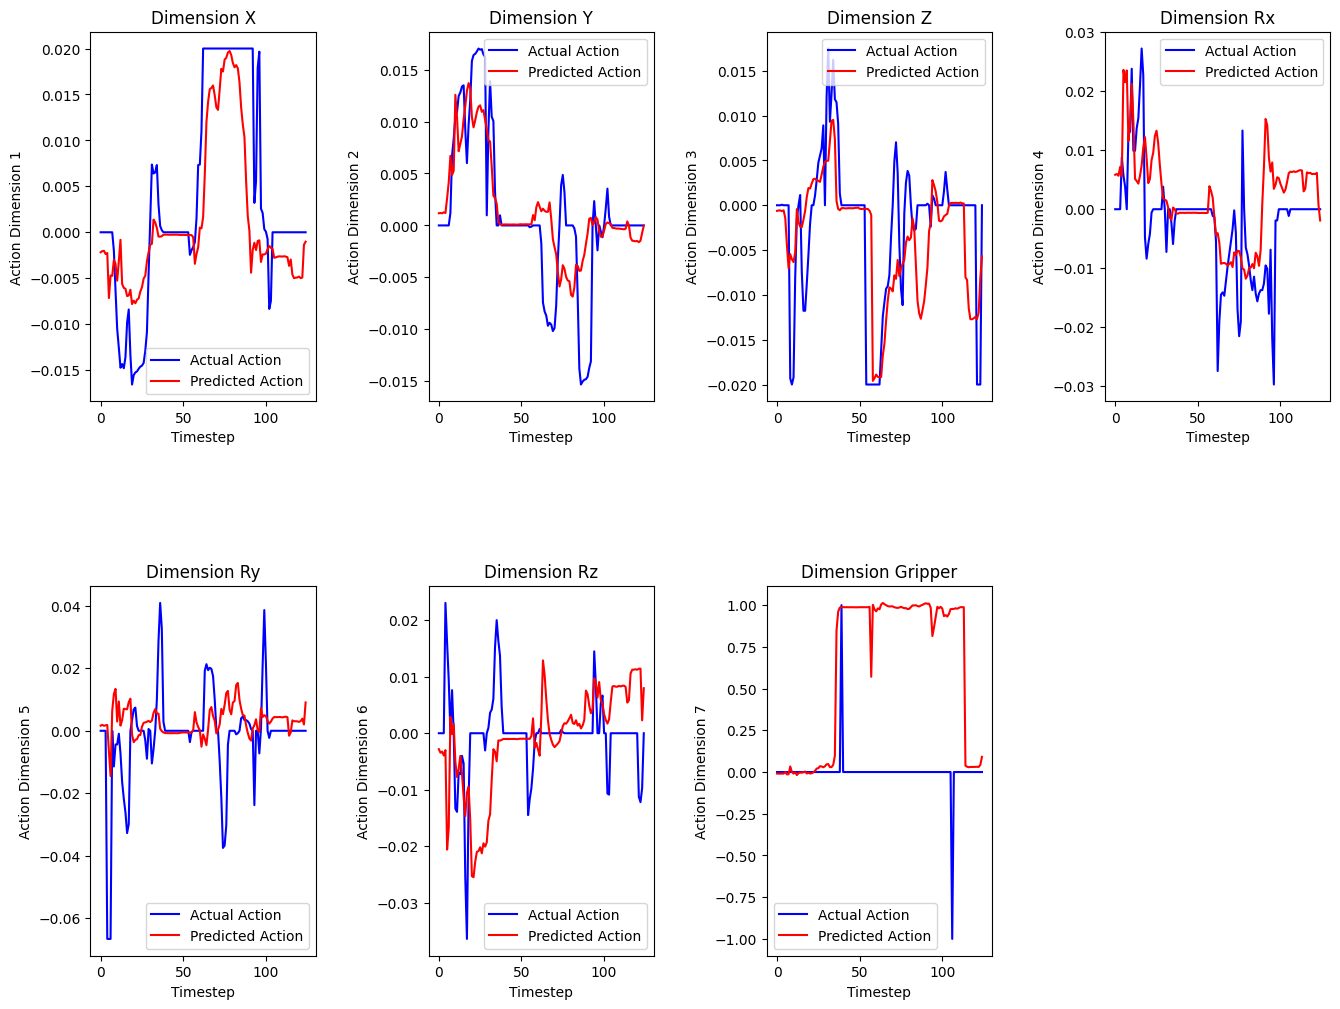

In [23]:
import matplotlib.pyplot as plt
# Create subplots for each dimension
# Create a 4x3 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 12))
# Flatten the axs array to iterate through each dimension
axs = axs.flatten()
# Loop through each dimension and plot actual and predicted actions
dimension_space = {1: 'X', 2: 'Y', 3: 'Z', 4: 'Rx', 5: 'Ry', 6: 'Rz', 7: 'Gripper'}

windowlength = 15
# compute the cumsum of the gripper action in a rolling window
gripper_cumsum_action = np.cumsum(predicted_actions[6][:windowlength-1]).tolist() + [sum(predicted_actions[6][i:i+windowlength]) for i in range(len(predicted_actions[6])-windowlength+1)]
for dim in range(7):
    axs[dim].plot(range(traj_len), actual_actions[dim], label='Actual Action', color='blue')
    # if dim == 6:
    #     axs[dim].plot(range(traj_len), np.clip(gripper_cumsum_action, -1, 1), label='Predicted Action', color='red')
    # else:
    axs[dim].plot(range(traj_len), predicted_actions[dim], label='Predicted Action', color='red')
    axs[dim].set_xlabel('Timestep')
    axs[dim].set_ylabel('Action Dimension {}'.format(dim + 1))
    axs[dim].set_title('Dimension {}'.format(dimension_space[dim + 1]))
    axs[dim].legend()


# Hide the remaining empty subplots
for dim in range(7, 8):
    axs[dim].axis('off')
plt.subplots_adjust(wspace = 0.5, hspace=0.5)